Importation des bibliotèques 

In [2]:
import torch
import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import torch.optim as optim

Importation du dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
]) # on définit une transformation qui permet de convertir en tenseur et de normaliser les 3 canaux couleurs de l'image

trainset = torchvision.datasets.CIFAR10(
    root='./data',  # Sous-dossier où les données seront stockées
    train=True,  # Charger les données d'entraînement
    download=True,  # Télécharger les données si elles ne sont pas encore présentes
    transform=transform  # Appliquer les transformations aux données
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,  # Charger les données de test
    download=True, 
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


Affichage de quelques éléments du dataset

Label: 9


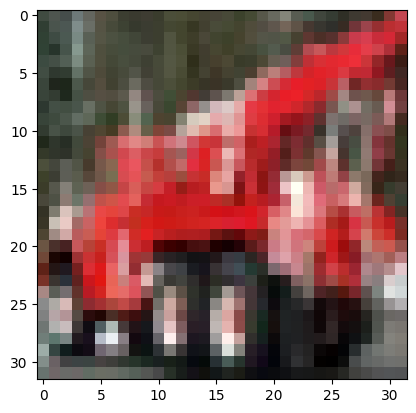

Label: 6


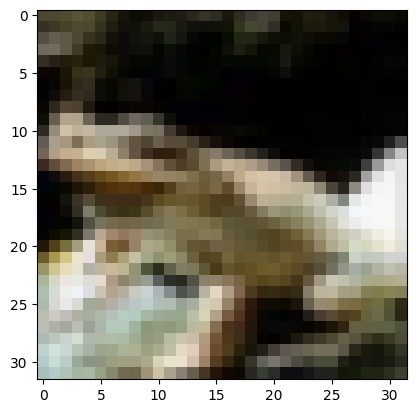

Label: 9


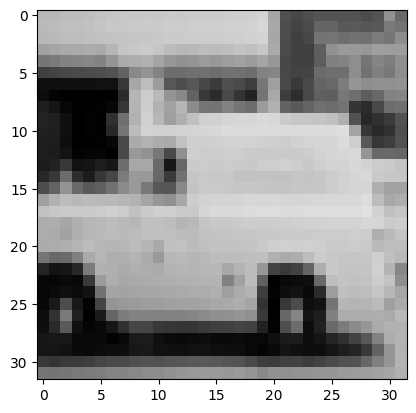

Label: 6


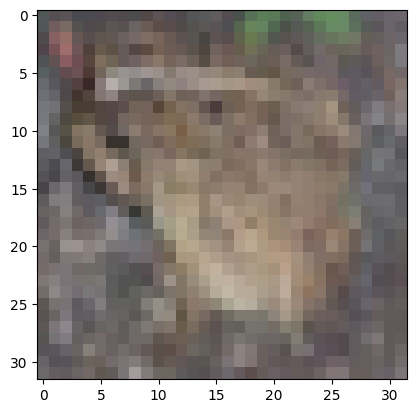

Label: 8


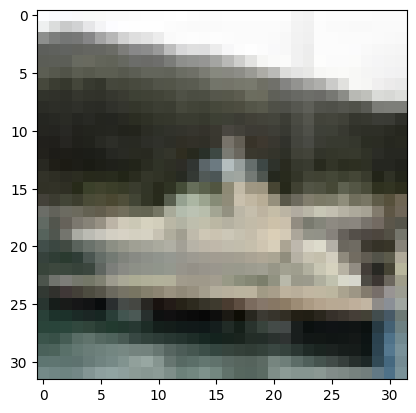

In [7]:
def imshow(img):
    img = img/2 + 0.5 
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))
    plt.show()


for i in range(5):
    random_index = rd.randint(0, len(trainset) - 1)
    img, label = trainset[random_index]
    print(f'Label: {label}')
    imshow(img)



Création d'un sous-dataset avec seulement des images d'avions et de voitures

In [6]:
def sous_base(dataset,labels_sélectionnés):
    sous_dataset=[]
    for i in range(len(dataset)):
        img,label = dataset[i]
        if label in labels_sélectionnés:
            sous_dataset.append(dataset[i])
    return sous_dataset

sous_trainset = sous_base(trainset,[0,1])
sous_testset = sous_base(testset,[0,1])

Résolution du problème de classification binaire : Définition des variables, du modèle et envoie vers le gpu

In [19]:
sous_train_loader= torch.utils.data.DataLoader(sous_trainset)
sous_test_loader = torch.utils.data.DataLoader(sous_testset)

X_sous_train = np.empty((len(sous_train_loader),3,32,32))
Y_sous_train = np.empty(len(sous_train_loader))

for i, (image,label) in enumerate(sous_train_loader):
    X_sous_train[i] = image.numpy()[0]
    Y_sous_train[i] = label.item()

X_sous_train = torch.tensor(X_sous_train, dtype=torch.float32)

Y_sous_train = torch.tensor(Y_sous_train, dtype=torch.float32)

permutation = np.random.permutation(len(X_sous_train))
X_sous_train, Y_sous_train =  X_sous_train[permutation], Y_sous_train[permutation]

X_sous_train_batches = X_sous_train[: 9984].view(156, 64, 3, 32, 32)
Y_sous_train_batches = Y_sous_train[: 9984].view(156,64)

X_sous_test = np.empty((len(sous_test_loader),3,32,32))
Y_sous_test = np.empty(len(sous_test_loader))

for i, (image,label) in enumerate(sous_test_loader):
    X_sous_test[i] = image.numpy()[0]
    Y_sous_test[i] = label.item()

X_sous_test = torch.tensor(X_sous_test, dtype=torch.float32)
Y_sous_test = torch.tensor(Y_sous_test, dtype=torch.float32)

permutation = np.random.permutation(len(X_sous_test))
X_sous_test, Y_sous_test =  X_sous_test[permutation], Y_sous_test[permutation]

X_sous_test_batches = X_sous_test[: 1984].view(31, 64, 3, 32, 32)
Y_sous_test_batches = Y_sous_test[: 1984].view(31,64)

model = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Couche convolutive
    nn.BatchNorm2d(64),  # Normalisation par lot
    nn.LeakyReLU(negative_slope=0.01),  # Fonction d'activation LeakyReLU
    
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(negative_slope=0.01),
    
    nn.MaxPool2d(kernel_size=2, stride=2),  # Couche de max pooling

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(negative_slope=0.01),
    
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(negative_slope=0.01),

    nn.MaxPool2d(kernel_size=2, stride=2),  # Autre couche de max pooling

    nn.Flatten(),  # Aplatir les sorties pour les couches fully connected
    nn.Linear(512 * 8 * 8, 256),  # Couche fully connected
    nn.BatchNorm1d(256),  # Normalisation par lot pour les fully connected
    nn.LeakyReLU(negative_slope=0.01),  # Activation LeakyReLU

    nn.Linear(256, 2),  # Couche de sortie pour 2 classes
    nn.LogSoftmax(dim=1)  # Utiliser LogSoftmax pour la classification binaire
    )

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (5): ReLU()
  (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=512, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=2, bias=True)
  (11): LogSoftmax(dim=1)
)

Entrainement pour la classification binaire

In [28]:
epochs = 10
running_loss = 0.0
total=0.0


for _ in range(epochs):
    for i, batch in enumerate(X_sous_train_batches):
        batch = batch.to(device)
        labels = Y_sous_train_batches[i].to(device).long()

        optimizer.zero_grad()

        outputs = model(batch)
        predicted = outputs.argmax(axis=1)

        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        diff = labels - predicted
        accuracy = len(diff[diff==0])/len(diff)
        running_loss += loss.item()
        total += labels.size(0)

    print(f'loss: {running_loss / total:.5f} accuracy: {accuracy:.3f}')







KeyboardInterrupt: 

On teste l'efficacité de la classification linéaire

In [29]:
total_correct = 0
total_samples = 0

with torch.no_grad():
    for i, batch in enumerate(X_sous_test_batches):
        batch = batch.to(device)
        labels = Y_sous_test_batches[i].to(device).long()
        outputs = model(batch)
        predicted = outputs.argmax(axis=1)
        diff = labels - predicted
        
        # Compte des échantillons corrects et total
        total_correct += (predicted == labels).sum().item()  # Total correct pour ce batch
        total_samples += labels.size(0)  # Nombre total d'échantillons

accuracy = total_correct / total_samples

print(f'accuracy = {100 * accuracy} %')
        



accuracy = 93.8508064516129 %
